In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle5 as pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.mixture import GaussianMixture as GMM
from transformer import DataTransformer

from geo_handler import (geo_loc, get_lat_long, take_closest, 
                         get_octa, reorganize_geocodes, get_nearest_loc,
                         augment_geocode_dict)

In [121]:
ADD_GEO_MAP = pickle.load(open('models/add_to_geo_map.pkl', 'rb'))
FOREX = pickle.load(open("models/exchange_rates.pkl", "rb"))

In [291]:
from bisect import bisect_left
from geopy.distance import geodesic
from collections import OrderedDict
from operator import getitem
import numpy as np


def geo_loc(point = None, address = None):
    
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="map.app")
    
    if address is None:
        try:
            location = geolocator.reverse(point)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid geo-coordinates !!'
    else:
        try:
            location = geolocator.geocode(address)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid Address !!'

def get_lat_long(address):
    try:
        point_ = ADD_GEO_MAP[address.strip()]
        return point_['latitude'], point_['longitude']
    except:
        point_ = geo_loc(address = address.strip())
        return point_[2]['lat'], point_[2]['lon']
    else:
        return 0, 0
    

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_octa(point):
    if float(point['latitude']) < 0:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90)
        else:
            return int(float(point['longitude']) / 90) + 2
    else:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90) + 4
        else:
            return int(float(point['longitude']) / 90) + 6


def reorganize_geocodes(geocodes_dictionary):
    from collections import OrderedDict
    coordinates = OrderedDict()
    
    coordinates['address'] = np.array(list(geocodes_dictionary.keys()))
    coordinates['latitude'] = np.array([row['latitude'] for name, row in geocodes_dictionary.items()])
    coordinates['longitude'] = np.array([row['longitude'] for name, row in geocodes_dictionary.items()])
    coordinates['category'] = np.array([row['category'] for name, row in geocodes_dictionary.items()])
    coordinates['distance'] = np.array([row['distance'] for name, row in geocodes_dictionary.items()])
    return coordinates

def augment_geocode_dict(geocodes):
    
    from geopy.distance import geodesic
    from collections import OrderedDict
    from operator import getitem
    
    for key in geocodes.keys():
        geocodes[key]['category'] = get_octa(geocodes[key])
        geocodes[key]['distance'] = float(geodesic((0, 0), (geocodes[key]['latitude'], geocodes[key]['longitude'])).km)
    geocodes = OrderedDict(sorted(geocodes.items(), key=lambda x: getitem(x[1], 'distance')))
    return geocodes


def get_nearest_loc(point, geocodes = None):
    from geopy.distance import geodesic
    if geocodes is None:
        return geo_loc(point)
    else:
        try:
            point_category = get_octa(point)
            geolist = geocodes['distance'][geocodes['category'] == point_category]
            distance = float(geodesic((0, 0), (point['latitude'], point['longitude'])).km)
            closest = np.where(geocodes['distance'] == take_closest(geolist, distance))

            closest_category = geocodes['category'][closest][0]
            closest_distance = geocodes['distance'][closest][0]
            # print(closest_category, point_category, abs(closest_distance - distance))
            if (closest_category != point_category) or abs(closest_distance - distance) > 10:
                return geo_loc(point)
            else:
                # return point_category, closest_category, distance, closest_distance, geocodes['address'][closest[0][0]]
                return geocodes['address'][closest[0][0]]

        except:
            return ''

def get_geocodes(address):
    try:
        # return coords_dict[address]
        location = COORDS[address]
        return [location['latitude'], location['longitude']]
    except:
        return ''

In [123]:
%%time
COORDS = reorganize_geocodes(augment_geocode_dict(ADD_GEO_MAP))

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.6 s


In [124]:
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

In [125]:
df.head()

,32a_val_dt,33b_cur,33b_orig_ord_amt,50a_payor_lon,50a_payor_lat,50f_payor_acct_nm:,50f_payor_name:,50f_payor_add_ln_1,50f_payor_add_ln_2,50f_payor_add_lat,...,50k_payor_add_lon,59f_ben_acct_num:,59f_ben_name,59f_ben_add_ln_1,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,2021-08-13,RUB,1544103.68,/0000000000000000000000000000009621,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,6099,ANGEL JAMES,1789 PHILLIPS RD,US GLENDALE,34.146942,-118.247847,SHA,NaN,NaN
1,2021-08-13,RUB,912070.95,/0000000000000000000000000000007346,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,874,JAKUB EVANS,369653 PEAR ST,US WELLS,47.566422,-99.650882,BEN,RUB,0.0
2,2021-08-13,RUB,21760302.59,/0000000000000000000000000000005305,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,5436,ZIGA MITCHELL,131041 DEBRA DR,US GROVER,42.795605,-110.929451,SHA,NaN,NaN
3,2021-08-13,RUB,878587.53,/0000000000000000000000000000004127,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,8707,YAEL DEMERS,50438 HAYMARKET ST,US MOORE,35.815612,-101.910435,SHA,NaN,NaN
4,2021-08-13,RUB,6696355.97,/0000000000000000000000000000006978,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,4326,NOEL PLANTE,43790 MOSHER CT,US WAUCHULA,27.547259,-81.811471,SHA,NaN,NaN


In [7]:
# %%time
# df[['59f_ben_add_lat', '59f_ben_add_lon']][:100] \
#                 .apply(lambda x: get_nearest_loc({'latitude' : x[0], 'longitude': x[1]}, 
#                         geocodes = COORDS), axis = 1)

In [127]:
# df.hist()

In [144]:
data = pd.DataFrame()

In [145]:
data = df[['33b_cur', '33b_orig_ord_amt']]

In [146]:
%%time
conditions = [
    ~df['50a_payor_lon'].isnull(), 
    ~df['50f_payor_add_ln_2'].isnull(), 
    ~df['50k_payor_add_ln_2'].isnull()]
choices = ['A', 'F', 'K']
data['src_xfrr_type'] = np.select(conditions, choices, default = "")

CPU times: user 51.8 ms, sys: 0 ns, total: 51.8 ms
Wall time: 50.9 ms


In [161]:
%%time
conditions = [
    ~df['50f_payor_add_lon'].isnull(),
    ~df["50k_payor_add_lon"].isnull()]
choices = [df["50f_payor_add_lon"], df["50k_payor_add_lon"]]
data['src_lon'] = np.select(conditions, choices, default=0)

CPU times: user 9.01 ms, sys: 450 µs, total: 9.46 ms
Wall time: 8.48 ms


In [162]:
%%time
conditions = [
    ~df["50f_payor_add_lat"].isnull(),
    ~df["50k_payor_add_lat"].isnull()]
choices = [df["50f_payor_add_lat"], df["50k_payor_add_lat"]]
data["src_lat"] = np.select(conditions, choices, default=0)

CPU times: user 8.27 ms, sys: 0 ns, total: 8.27 ms
Wall time: 7.29 ms


In [163]:
data[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]

In [164]:
data["charge_dtls"] = df.loc[:, "71A_chg_dtls"]

In [165]:
data[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]

In [168]:
data[(data['src_lon'] == 0) & (data['src_xfrr_type'] != 'A')]

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt


In [170]:
data[(data['src_lon'] == 0) & (data['src_xfrr_type'] == 'k')]

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt


In [171]:
data["charge_dtls_cur"] = data["charge_dtls_cur"].replace(np.nan, "999", regex=True)
data["charge_dtls_amt"] = data["charge_dtls_amt"].replace(np.nan, 0, regex=True)

data["target_lat"] = data["target_lat"].replace(np.nan, 0, regex=True)
data["target_lon"] = data["target_lon"].replace(np.nan, 0, regex=True)
data["src_lon"] = data["src_lon"].replace(np.nan, 0, regex=True)
data["src_lat"] = data["src_lat"].replace(np.nan, 0, regex=True)

In [172]:
data.columns

Index(['33b_cur', '33b_orig_ord_amt', 'src_xfrr_type', 'src_lon', 'src_lat',
       'target_lat', 'target_lon', 'charge_dtls', 'charge_dtls_cur',
       'charge_dtls_amt'],
      dtype='object')

In [173]:
data

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1544103.68,A,0.000000,0.000000,34.146942,-118.247847,SHA,999,0.0
1,RUB,912070.95,A,0.000000,0.000000,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,21760302.59,A,0.000000,0.000000,42.795605,-110.929451,SHA,999,0.0
3,RUB,878587.53,A,0.000000,0.000000,35.815612,-101.910435,SHA,999,0.0
4,RUB,6696355.97,A,0.000000,0.000000,27.547259,-81.811471,SHA,999,0.0
...,...,...,...,...,...,...,...,...,...,...
379521,USD,8339.00,A,0.000000,0.000000,37.653540,-122.416866,SHA,999,0.0
379522,USD,4001.56,F,-96.707775,40.808886,39.793896,-74.223206,BEN,USD,0.0
379523,USD,4456.00,F,-81.822065,37.941215,39.808320,-104.933868,OUR,999,0.0
379524,USD,8836.10,A,0.000000,0.000000,40.366432,-105.502855,SHA,999,0.0


In [174]:
numerical_columns = data._get_numeric_data().columns
discrete_columns = [col for col in data.columns if col not in numerical_columns]

In [175]:
def generate(dataframe, num_samples=1000, n_components = 10):
    numerical_columns = dataframe._get_numeric_data().columns
    discrete_columns = [col for col in dataframe.columns if col not in numerical_columns]
    
    _transformer = DataTransformer()
    _transformer.fit(dataframe, discrete_columns)
    data = _transformer.transform(dataframe)
    gmm = GMM(n_components = n_components, covariance_type = "full", random_state = 0).fit(data)
    Xnew = gmm.sample(num_samples)
    Xnew_inv = _transformer.inverse_transform(Xnew[0])
    Xnew_inv["label"] = Xnew[1]
    return gmm, _transformer, Xnew_inv

In [361]:
%%time
model, transformer, samples = generate(data, num_samples = 1000, n_components = 15)

CPU times: user 14min 54s, sys: 11min 58s, total: 26min 52s
Wall time: 10min 33s


In [362]:
%%time
with open('models/GMM_MODEL_10.pkl', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('models/GMM_TRANSFORMER.pkl', 'wb') as file:
    pickle.dump(transformer, file, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 2.31 ms, sys: 3 ms, total: 5.32 ms
Wall time: 17.9 ms


In [363]:
# %%time
# model = pickle.load(open('models/GMM_MODEL.pkl', 'rb'))
# transformer = pickle.load(open('models/GMM_TRANSFORMER.pkl', 'rb'))

In [388]:
%%time
samples = transformer.inverse_transform(model.sample(400000)[0])

CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 4.41 s


In [507]:
samples

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1.777555e+05,A,0.000898,-0.000233,43.354841,-118.088277,OUR,999,7.397045e-06
1,RUB,2.994681e+06,A,-0.002809,-0.000340,32.857243,-100.964917,SHA,999,-1.191162e-06
2,RUB,2.886494e+06,A,0.002552,-0.000056,38.306014,-88.740255,SHA,999,2.481430e-06
3,RUB,3.680742e+06,A,0.001321,-0.000498,38.742025,-79.552326,OUR,999,3.977572e-06
4,RUB,2.924897e+06,A,0.000154,-0.000424,31.954349,-81.233302,SHA,999,1.756170e-06
...,...,...,...,...,...,...,...,...,...,...
399995,RUB,1.647840e+06,F,-83.912394,36.875976,43.843799,-72.914794,BEN,RUB,-7.025361e-07
399996,RUB,1.591435e+05,F,-79.612803,39.984627,40.955133,-73.514552,BEN,RUB,-1.138340e-05
399997,RUB,1.029417e+06,F,-79.466005,40.090516,42.985735,-77.453620,BEN,RUB,8.676130e-08
399998,RUB,7.666138e+05,F,-123.185665,42.343560,42.084039,-69.467722,BEN,RUB,-4.400980e-07


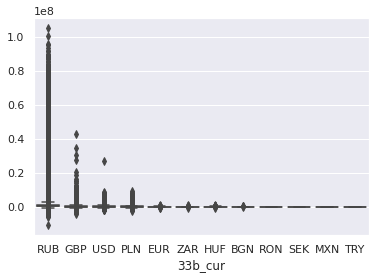

In [520]:
import seaborn as sns
# sns.set(style="whitegrid")
sns.set()

ax = sns.boxplot(x = samples['33b_cur'], y = samples['33b_orig_ord_amt'].values)
plt.show()

In [389]:
def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")
    
    plt.subplot(122)
    sns.heatmap(samples.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")

In [390]:
def attr_plot(data, samples):
    for col in data.columns:
        if col not in discrete_columns:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
        else:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data)
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples)
            plt.xticks(rotation=45)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


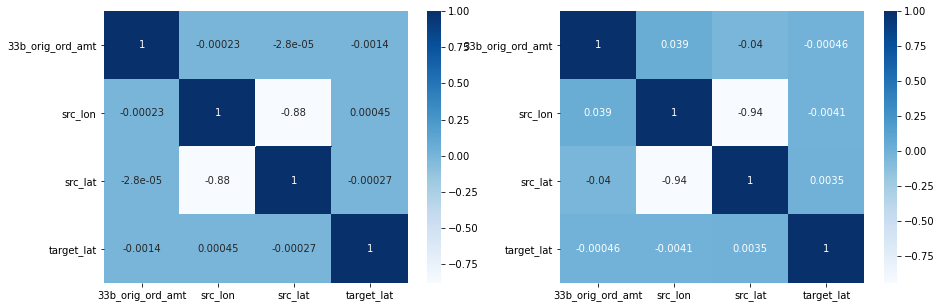

In [391]:
%time
corrplot(data, samples)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


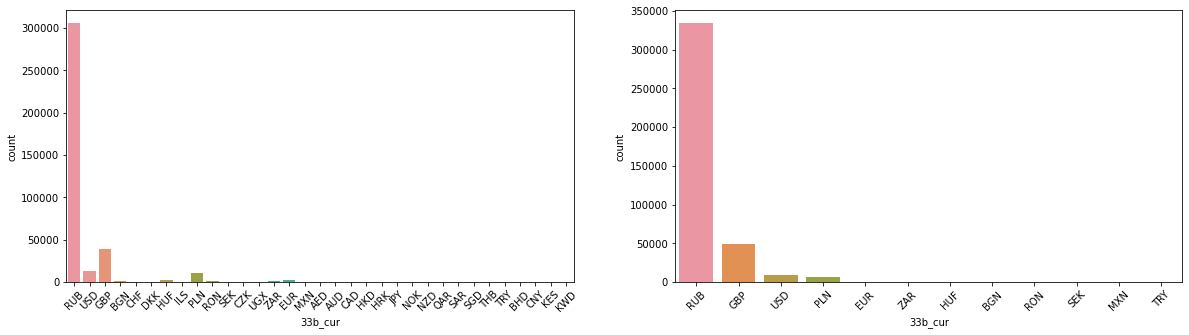

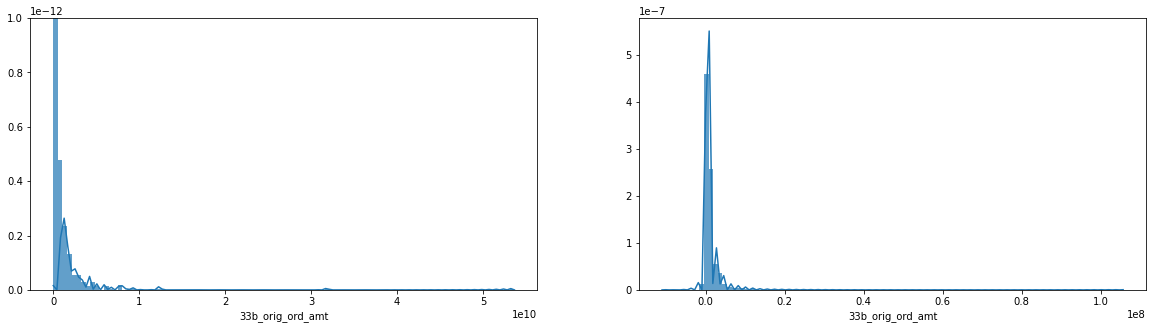

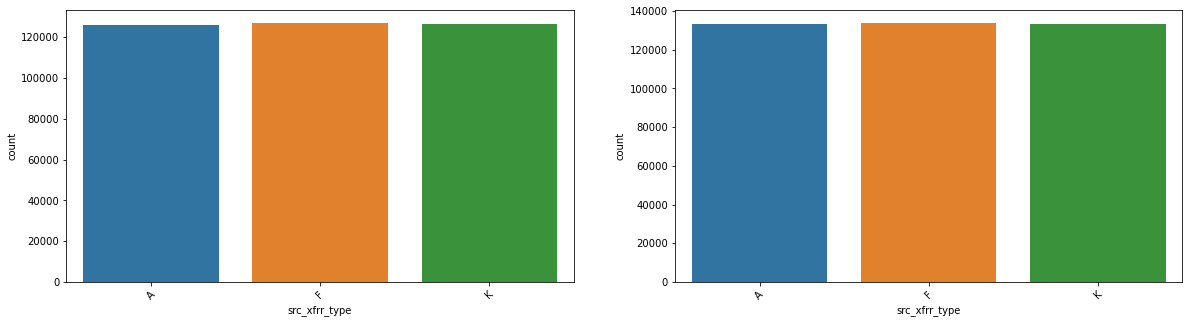

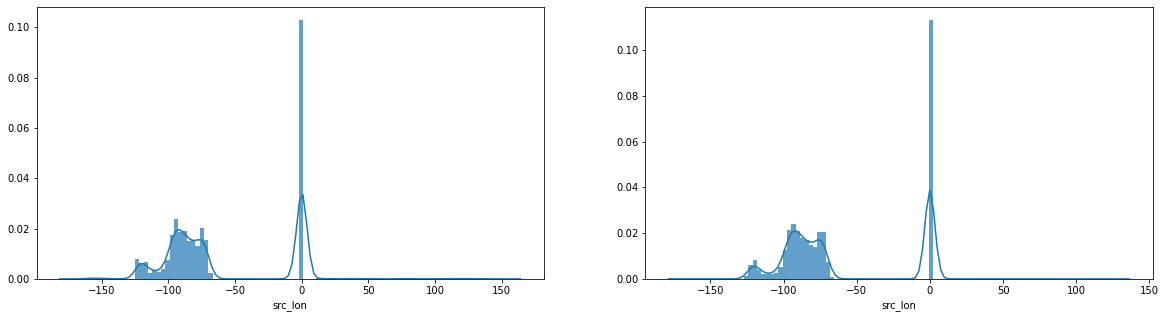

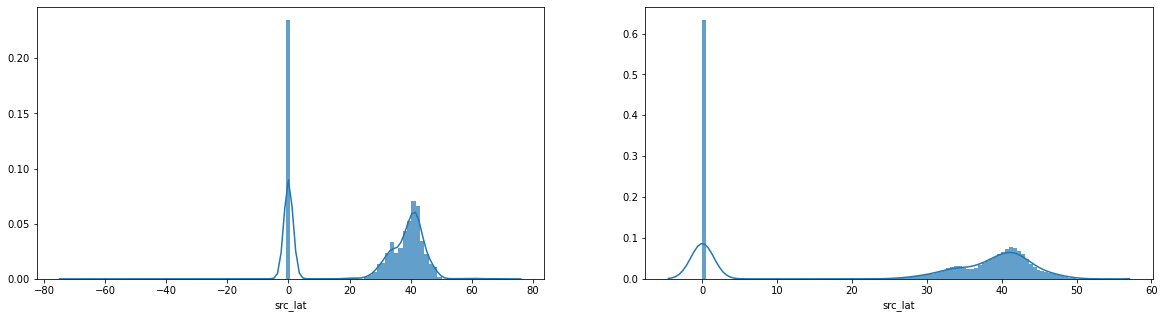

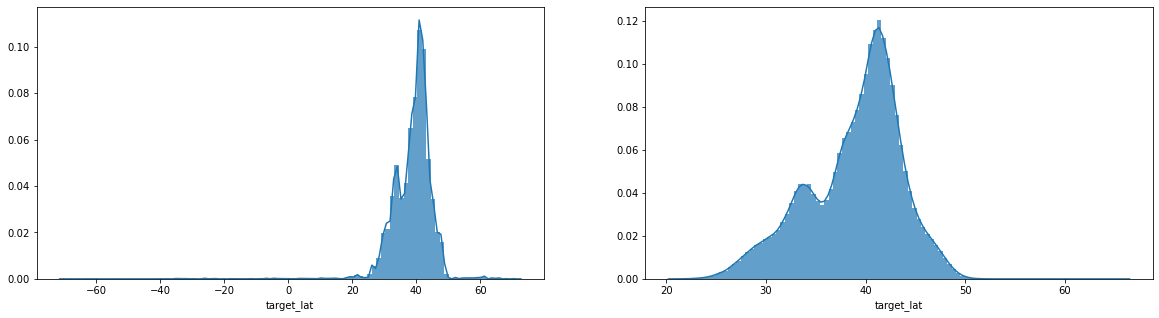

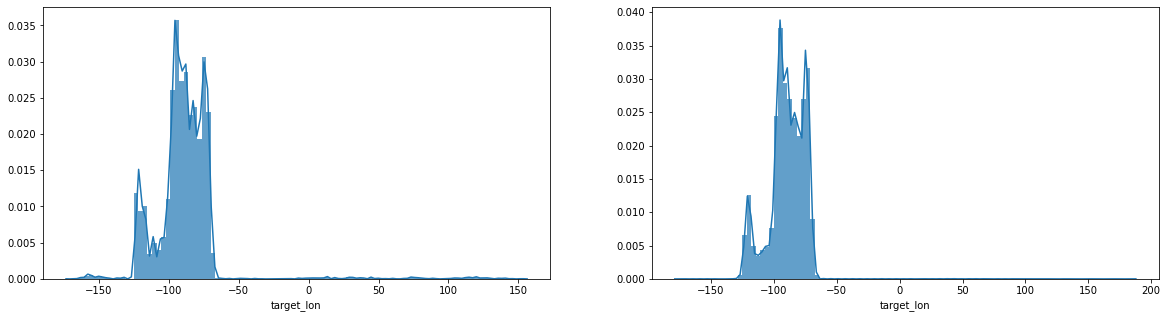

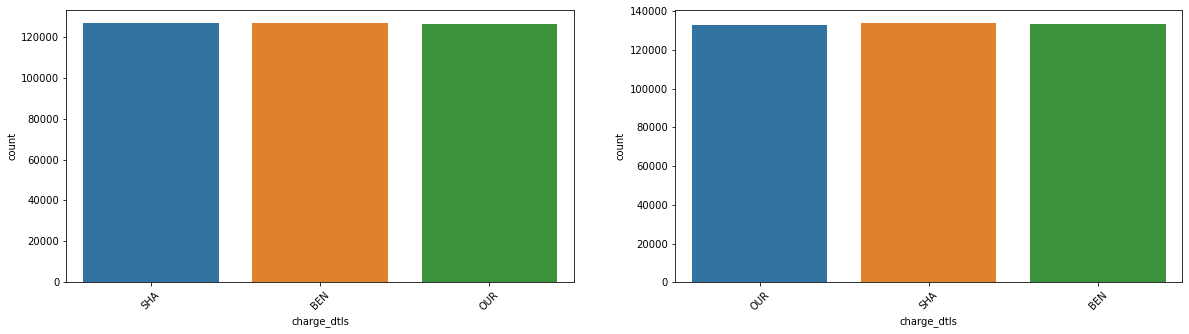

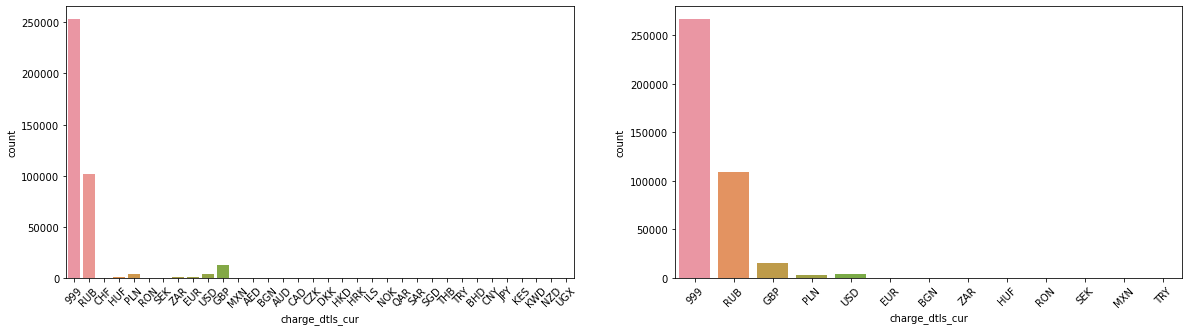

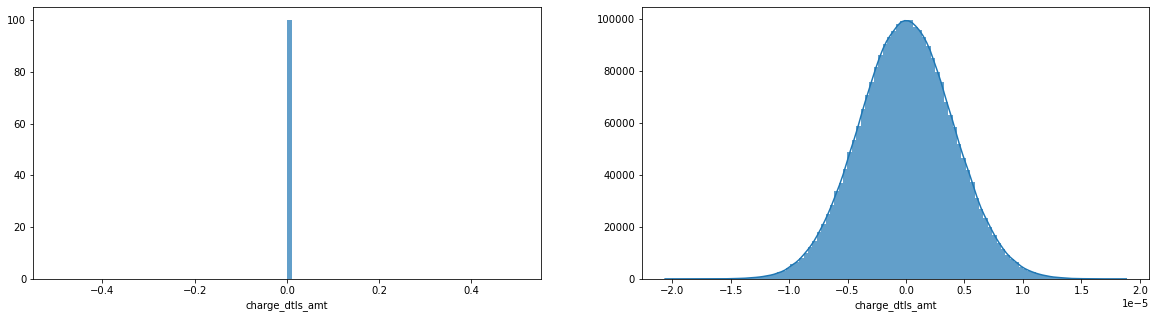

In [392]:
%time
attr_plot(data, samples)

In [393]:
# pickle.dump(model, open('models/GMM_MODEL.pkl', 'wb'))

In [394]:
# pickle.dump(transformer, open('models/GMM_TRANSFORMER.pkl', 'wb'))

In [396]:
samples.columns

Index(['33b_cur', '33b_orig_ord_amt', 'src_xfrr_type', 'src_lon', 'src_lat',
       'target_lat', 'target_lon', 'charge_dtls', 'charge_dtls_cur',
       'charge_dtls_amt'],
      dtype='object')

In [372]:
df.columns

Index(['32a_val_dt', '33b_cur', '33b_orig_ord_amt', '50a_payor_lon',
       '50a_payor_lat', '50f_payor_acct_nm:', '50f_payor_name:',
       '50f_payor_add_ln_1', '50f_payor_add_ln_2', '50f_payor_add_lat',
       '50f_payor_add_lon', '50k_payor_acct_num:', '50k_payor_name',
       '50k_payor_add_ln_1', '50k_payor_add_ln_2', '50k_payor_add_lat',
       '50k_payor_add_lon', '59f_ben_acct_num:', '59f_ben_name',
       '59f_ben_add_ln_1', '59f_ben_add_ln_2', '59f_ben_add_lat',
       '59f_ben_add_lon', '71A_chg_dtls', '71f_chg_dtls_cur',
       '71f_chg_dtls_amt'],
      dtype='object')

In [397]:
# simple wrapper code around serial_calc to parallelize the work
def parallel_calc(df, func, n_core, col):
    futs = []
    df_split = np.array_split(df, n_core)
    # pool = concurrent.futures.ThreadPoolExecutor(max_workers = n_core)
    pool = concurrent.futures.ProcessPoolExecutor(max_workers = n_core)
    apply_partial = partial(func, col=col)
    return pd.concat(pool.map(apply_partial, df_split))

In [480]:
%%time
def _50f_payor_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS) if row[col][0] == 'F' else ''

def proc_50f_payor_add_ln_2(df, col):
    apply_partial = partial(_50f_payor_add_ln_2, col=col)
    # df['50f_payor_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)

###################

def _50k_payor_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS) if row[col][0] == 'K' else ''

def proc_50k_payor_add_ln_2(df, col):
    apply_partial = partial(_50k_payor_add_ln_2, col=col)
    # df['50k_payor_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)

##################


def _59f_ben_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS)

def proc_59f_ben_add_ln_2(df, col):
    apply_partial = partial(_59f_ben_add_ln_2, col=col)
    # df['59f_ben_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)


CPU times: user 0 ns, sys: 41 µs, total: 41 µs
Wall time: 44.8 µs


In [447]:
%%time
revert = pd.DataFrame()

for col in df.columns:
    if col in samples.columns:
        revert[col] = samples[col]
        
revert['50a_payor_lon'] = ''
revert['50a_payor_lat'] = ''
revert['50f_payor_acct_nm:'] = ''
revert['50f_payor_name:'] = ''
revert['50f_payor_add_ln_1'] = ''
revert['src_xfrr_type'] = samples['src_xfrr_type']

CPU times: user 36.3 ms, sys: 8.72 ms, total: 45 ms
Wall time: 44.2 ms


In [478]:
%%time
revert['50f_payor_add_ln_2'] = ''
revert.loc[revert['src_xfrr_type'] == 'F', '50f_payor_add_ln_2'] = parallel_calc(samples[samples['src_xfrr_type'] == 'F'], 
                                                                             proc_50f_payor_add_ln_2, 8, 
                                                                             ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 385 ms, sys: 267 ms, total: 652 ms
Wall time: 1min 9s


In [481]:
%%time
condition = [samples['src_xfrr_type'] == 'F', samples['src_xfrr_type'] != 'F']
choice = [samples['src_lat'], 0]
revert['50f_payor_add_lat'] = np.select(condition, choice, default = 0)
    
condition = [samples['src_xfrr_type'] == 'F']
choice = [samples['src_lon']]
revert['50f_payor_add_lon'] = np.select(condition, choice, default = 0)

condition = [samples['src_xfrr_type'] == 'K']
choice = [samples['src_lat']]
revert['50k_payor_add_lat'] = np.select(condition, choice, default = 0)

condition = [samples['src_xfrr_type'] == 'K']
choice = [samples['src_lon']]
revert['50k_payor_add_lon'] = np.select(condition, choice, default = 0)

CPU times: user 108 ms, sys: 366 µs, total: 108 ms
Wall time: 107 ms


In [483]:
%%time
revert['50k_payor_add_ln_2'] = ''
revert.loc[revert['src_xfrr_type'] == 'K', '50k_payor_add_ln_2'] = parallel_calc(samples[samples['src_xfrr_type'] == 'K'], 
                                                                        proc_50k_payor_add_ln_2, 8, 
                                                                        ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 420 ms, sys: 282 ms, total: 702 ms
Wall time: 1min 11s


In [487]:
%%time
revert['59f_ben_add_ln_2'] = parallel_calc(samples, 
                             proc_59f_ben_add_ln_2, 8, 
                             ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 529 ms, sys: 255 ms, total: 784 ms
Wall time: 2min 54s


In [488]:
%%time
revert['59f_ben_add_lat'] = samples['target_lat']
revert['59f_ben_add_lon'] = samples['target_lon']
revert['71A_chg_dtls'] = samples['charge_dtls']
revert['71f_chg_dtls_cur'] = samples['charge_dtls_cur']
revert['71f_chg_dtls_amt'] = samples['charge_dtls_amt']

CPU times: user 8.01 ms, sys: 3.86 ms, total: 11.9 ms
Wall time: 11 ms


In [495]:
revert.drop(revert[revert['50f_payor_add_ln_2'] == 'Invalid geo-coordinates !!'].index,inplace=True)
revert.drop(revert[revert['50k_payor_add_ln_2'] == 'Invalid geo-coordinates !!'].index,inplace=True)
revert.drop(revert[revert['59f_ben_add_ln_2'] == 'Invalid geo-coordinates !!'].index,inplace=True)

In [496]:
revert.drop(revert[revert['33b_orig_ord_amt'] < 0].index, inplace=True)

In [497]:
revert.shape

(231561, 20)

In [498]:
revert.to_csv('revert_samples.csv', index=False)